In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure plots are displayed inline
%matplotlib inline

Otsu's calculated threshold value: 101.0


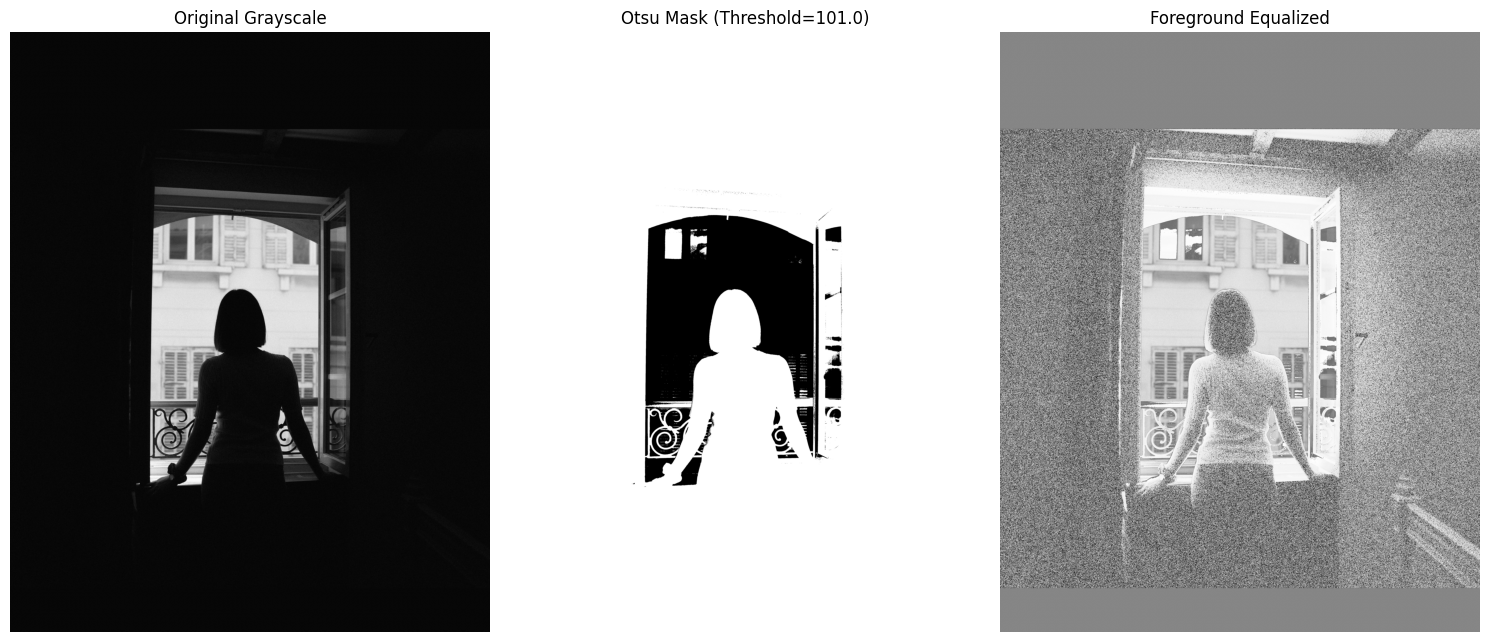

Images saved.


In [3]:
img_path = '../images/looking_out.jpg' 
img_bgr = cv2.imread(img_path)

if img_bgr is None:
    print(f"Error: Could not load image from {img_path}")
else:
    # Convert to Grayscale (Required for Otsu) [cite: 20]
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # --- 2. Otsu's Thresholding [cite: 21] ---
    # We use THRESH_BINARY_INV because the foreground (woman) is dark and background (window) is light.
    # Otsu's algorithm automatically finds the optimal threshold value 'ret'.
    ret, mask = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    print(f"Otsu's calculated threshold value: {ret}") # [cite: 22]

    # --- 3. Masked Histogram Equalization [cite: 23] ---
    # Standard cv2.equalizeHist works on the whole image. We need to do it manually for just the masked area.
    
    # Copy original grayscale image to create the output
    img_equalized_foreground = img_gray.copy()
    
    # A. Extract only the foreground pixels (where mask is white)
    foreground_pixels = img_gray[mask == 255]
    
    # B. Calculate Histogram of ONLY the foreground
    hist, _ = np.histogram(foreground_pixels, 256, [0, 256])
    
    # C. Calculate CDF
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf, 0) # Mask zeros
    # Normalize CDF to [0, 255]
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')
    
    # D. Map the foreground pixels to new values
    equalized_pixels = cdf_final[foreground_pixels]
    
    # E. Put them back into the image
    img_equalized_foreground[mask == 255] = equalized_pixels

    # --- 4. Visualization ---
    plt.figure(figsize=(15, 10))

    # Original Grayscale
    plt.subplot(1, 3, 1)
    plt.imshow(img_gray, cmap='gray')
    plt.title('Original Grayscale')
    plt.axis('off')

    # Binary Mask (The Foreground)
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Otsu Mask (Threshold={ret})')
    plt.axis('off')

    # Result: Equalized Foreground + Original Background
    plt.subplot(1, 3, 3)
    plt.imshow(img_equalized_foreground, cmap='gray')
    plt.title('Foreground Equalized')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # --- 5. Save Output ---
    output_dir = '../images/outputs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    cv2.imwrite(os.path.join(output_dir, 'q4_otsu_mask.jpg'), mask)
    cv2.imwrite(os.path.join(output_dir, 'q4_foreground_equalized.jpg'), img_equalized_foreground)
    print("Images saved.")